In [1]:
## 자산 및 전략에 대해 기본적인 평가를 수행할 수 있습니다.

In [1]:
# 기본 패키지
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
## fred = Fred(api_key='Your API Key')

fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf
from quant_functions import anal_funcs
import baseloader

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## DataLoad

In [4]:
dataloader = baseloader.BaseLoader()

In [5]:
dataloader.save_df()

[*********************100%***********************]  4 of 4 completed


0.9182341626963042
0.8698779253276526
0.8865270424252473
1.0151285007598523
0.6598882010371654
0.7087072701705324
0.9953424146502147


[*********************100%***********************]  10 of 10 completed


0.9945605697026642
0.9936281480657471
1.0443803407220482
3.0318084752479884
2.9809004058390856
-0.3041254897424372
0.43384216899267486
0.1715652100994465
0.8731003277541332
1.023300778582009


In [7]:
df_imp = pd.read_csv('trend_data.csv', index_col=0)
df_imp.index = pd.to_datetime(df_imp.index)

In [10]:
## MDD 계산
data = df_imp['QQQ'].copy()
peak = data.expanding(min_periods=1).max()
drawdown = (data - peak) / peak

In [12]:
drawdown.tail(10)

Date
2025-02-18    0.000000
2025-02-19    0.000000
2025-02-20   -0.004245
2025-02-21   -0.024911
2025-02-24   -0.036421
2025-02-25   -0.048562
2025-02-26   -0.046263
2025-02-27   -0.072750
2025-02-28   -0.058107
2025-03-03   -0.078718
Name: QQQ, dtype: float64

## GTAA

In [28]:
## 프로젝트마다 필요한 데이터
tickers = ['SPY', 'EFA', 'IEF', 'GSG', 'VNQ']
gtaa_ori = yf.download(tickers, ignore_tz = True, auto_adjust=True)
gtaa_ori = gtaa_ori['Close'].dropna()

[*********************100%***********************]  5 of 5 completed


In [29]:
# TAA
class TacticalAssetAllocation:
    def __init__(self, data, cash_asset='Cash', sma_period=10):
        """
        GTAA 전략 구현 클래스
        data: 시계열 데이터 (Date, 종가 포함)
        cash_asset: 매도 시 현금 보유 자산
        sma_period: 이동평균 기간
        initial_capital: 초기 투자 금액
        """
        self.data = data.copy()
        self.sma_period = sma_period
        self.cash_asset = cash_asset
        self.initial_capital = 1000000000
        
    def calculate_sma(self):
        """ 각 자산의 10개월 이동평균 계산 """
        sma_df = self.data.copy()
        sma_period = self.sma_period
        for col in sma_df.columns:
                sma_df[f'{col}_SMA'] = sma_df[col].rolling(window=sma_period, min_periods=sma_period).mean()
        return sma_df
    
    def generate_signals(self):
        """ 매매 신호 생성 (가격 > 이동평균: 매수(1), 그렇지 않으면 현금(0)) """
        sma_df = self.calculate_sma()
        data = self.data.copy()
        signal_df = pd.DataFrame(index=sma_df.index)
        
        for col in data.columns:
                signal_df[col] = (sma_df[col] > sma_df[f'{col}_SMA']).astype(int)

        return signal_df
    
    def backtest(self):
        cash_asset = self.cash_asset
        data = self.data.copy()
        initial_capital = self.initial_capital
        portfolio = self.generate_signals()
        portfolio = portfolio.shift(1).fillna(0)
        
        # 각 월별 투자 자산 수 계산
        num_assets = portfolio.drop(columns=[cash_asset]).sum(axis=1).replace(0, np.nan)  
        # 매수 신호가 있는 자산에 동일 가중 할당
        weights = portfolio.drop(columns=[cash_asset]).div(num_assets, axis=0).fillna(0)
        # 현금 비중 계산 (투자되지 않은 비중을 현금으로 유지)
        weights[cash_asset] = 1 - weights.sum(axis=1)

        # 자산별 수익률 계산
        returns = data.pct_change().fillna(0)

        # 전략 포트폴리오 수익률 계산
        portfolio_returns = (weights * returns).sum(axis=1)

        # 초기 투자 금액 기준으로 포트폴리오 가치 계산
        portfolio_value = (1 + portfolio_returns).cumprod() * initial_capital

        portfolio = pd.DataFrame({
            'Value': portfolio_value.values
        }, index=portfolio_value.index)
        
        portfolio = portfolio/portfolio.iloc[0] * 100
        
        return portfolio

In [30]:
monthly_df = df_imp.resample('M').last()
dataset = monthly_df[['TQQQ', 'SGOV']]

# 전략 실행 및 백테스트
taa = TacticalAssetAllocation(dataset, 'SGOV', 10)

In [33]:
gtaa_ori['SGOV'] = df_imp['SGOV']

In [46]:
monthly_df = gtaa_ori.resample('M').last()
dataset = monthly_df

# 전략 실행 및 백테스트
taa = TacticalAssetAllocation(dataset, 'SGOV', 10)

In [47]:
portfolio = taa.backtest()

In [48]:
test_df = monthly_df.copy()
test_df['GTAA'] = portfolio['Value']
## 판단 이후 시점부터
test_df = test_df[10:]
test_df = test_df/test_df.iloc[0] * 100

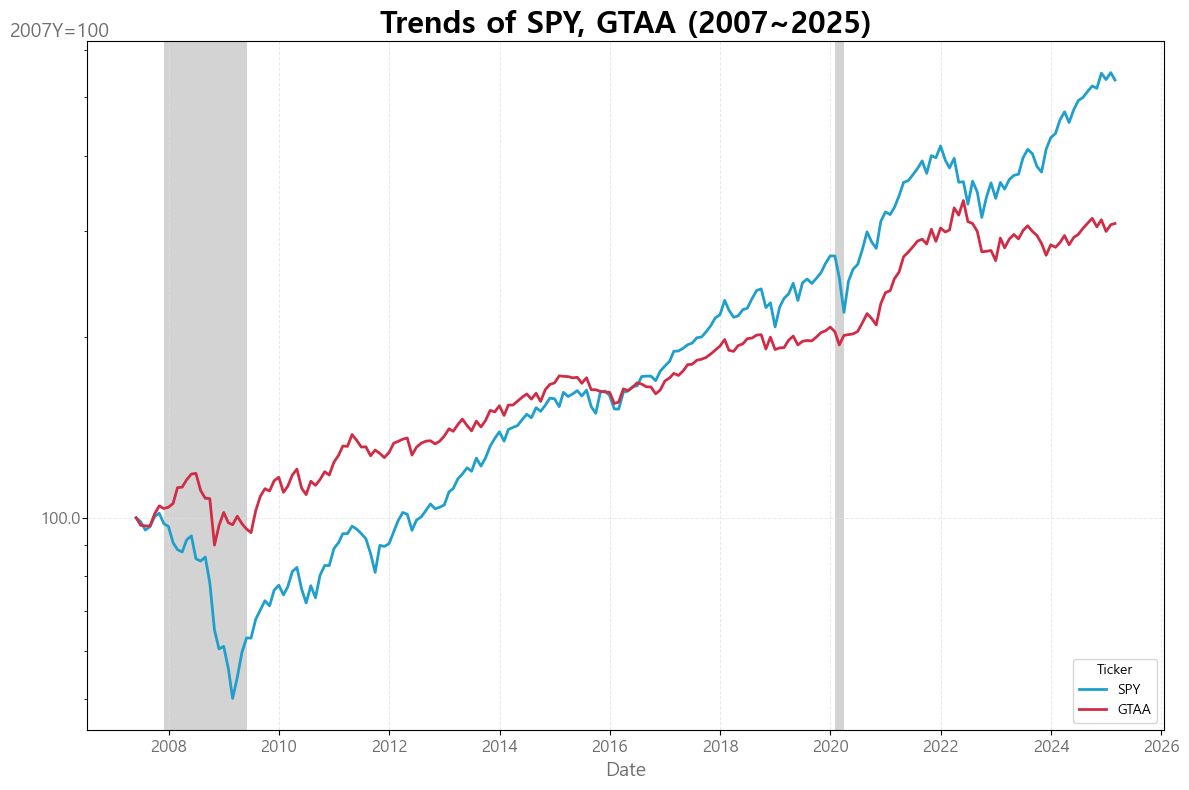

In [49]:
assets = ['SPY', 'GTAA']
gm.trend_plot(test_df, assets, colors=[mycolors['color_cont'], mycolors['color_norm']])

In [15]:
monthly_df = df_imp.resample('M').last()
dataset = monthly_df[['TQQQ', 'SGOV']]

# 전략 실행 및 백테스트
taa = TacticalAssetAllocation(dataset, 'SGOV', 10)

In [16]:
portfolio = taa.backtest()

In [17]:
test_df = monthly_df.copy()
test_df['GTAA'] = portfolio['Value']
## 판단 이후 시점부터
test_df = test_df[10:]
test_df = test_df/test_df.iloc[0] * 100

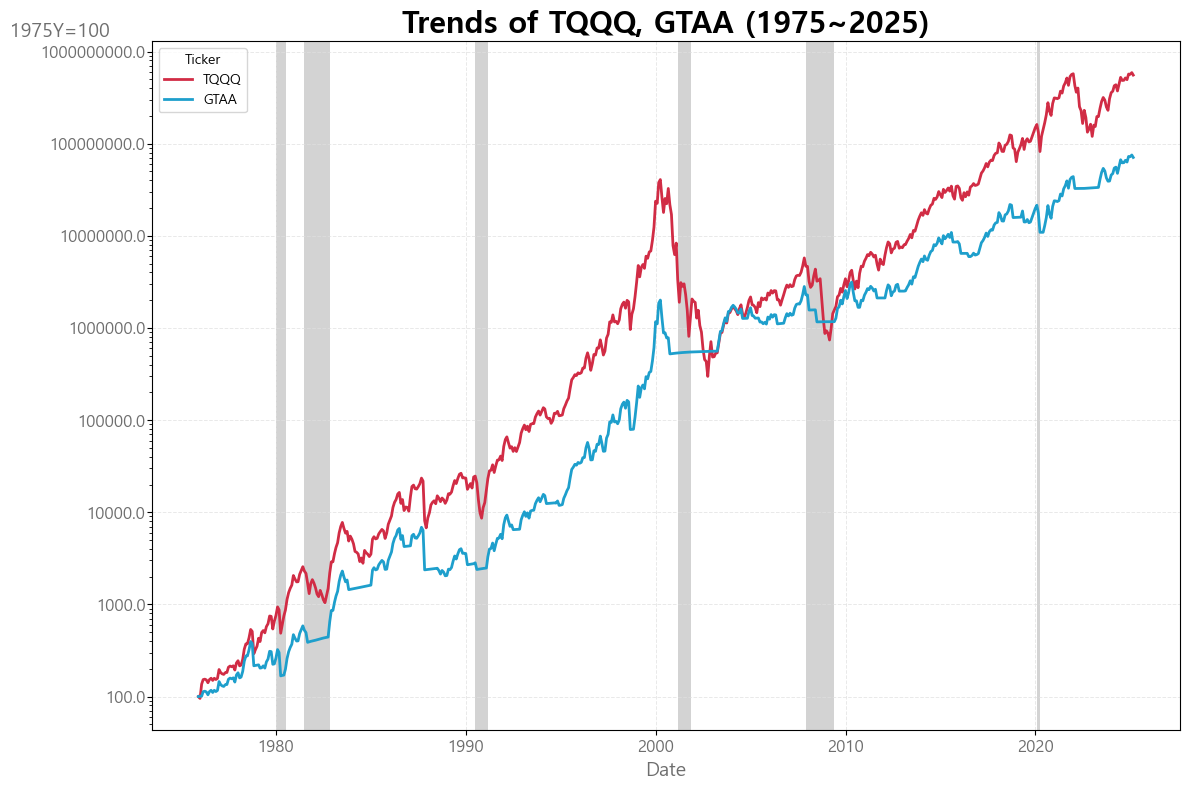

In [21]:
assets = ['TQQQ', 'GTAA']
gm.trend_plot(test_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

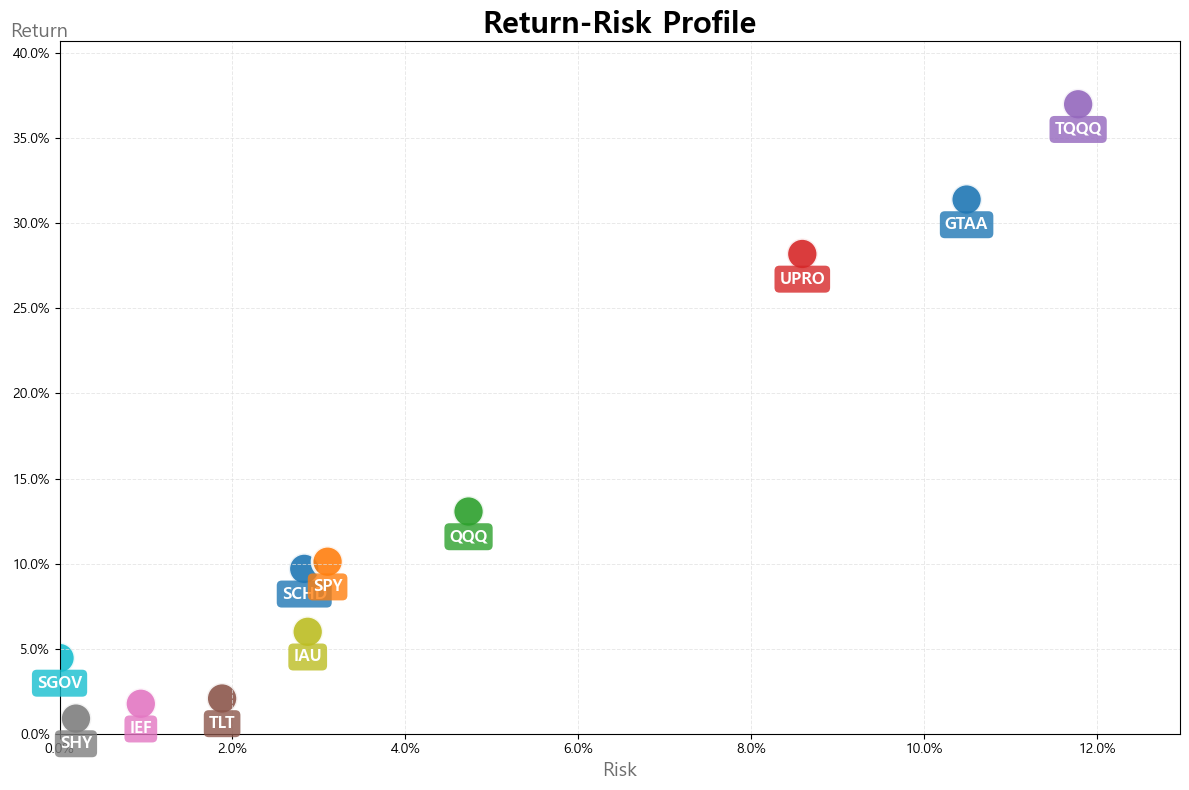

In [31]:
return_risk_df = anal_funcs.get_Vol_report(test_df, method='a', rf=0, unit='monthly')
gm.return_risk_profile_plot(return_risk_df, test_df.columns)

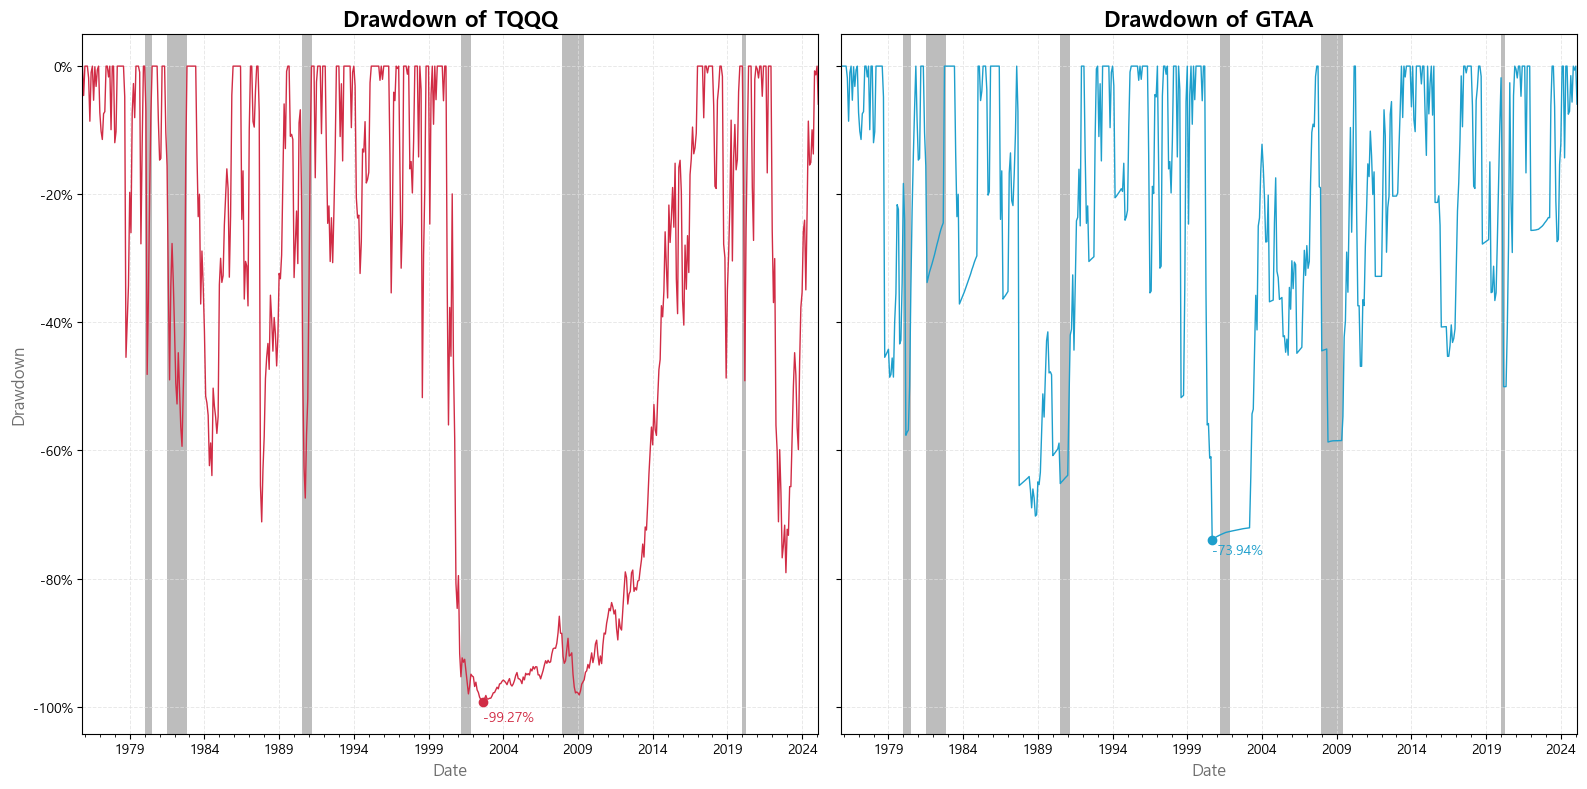

In [32]:
gm.drawdown_plot(test_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])